# Landau Zener Effect
Hamiltonian with a linearly diverging energy levels with a small coupling $U$,
$$ H(t)  = vt Z + U X $$

In this notebook, I calculated the population in the instantaneous states as a function of time at various values of $U/v$. As the ratio decreases, the transition probability increases.

Next, I will compute the final state population as a function of $U/v$ and compare that with the formula given by the Landau-Zener theory for linear variation of the energy separation.

I then compute the transitions for more general pulses for the energy level separation, and compare with the Landau-Zener theory prediction if the first order time-derivative of the pulse is used in the formula.

In [70]:
import numpy as np
from scipy.integrate import solve_ivp
from quantum.floquet import dynamics
from quantum.utils import plotting as PLT
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])

In [198]:
def propagator(tmax, Hfunc, dt = 0.1, psi=None):
    """
    Trotter-Suzuki method to compute propagator with the time-ordered exponential of a matrix-valued function
    H(t) = Hfunc(t)
    U(t) = exp(idt H(3dt))exp(idt H(2dt))exp(idt H(dt))exp(idt H(0))
    Args:
        tmax (float) : specifies the time span as [0,tmax]
        Hfunc (callable) : Hfunc(t) must return a matrix at time t, and for each t the matrix must be the same size
    Keywords:
        dt (float) : time-step in the Trotter-Suzuki scheme (see above)
        psi (initial state) : If not none, specifies the initial vector for the state at time t=0
    Returns:
        U, (psit,time),resid
    """
    dt = tmax/np.ceil(tmax/dt)
    time = np.arange(0, tmax+dt/2, dt)
    U = np.eye(Hfunc(time[0]).shape[0]).astype(complex)
    Uprev = U.copy()
    Uprev2 = U.copy()
    resid = []
    psit = np.zeros((len(time),2),dtype=complex)
    psit[0] = psi
    phit = np.zeros((len(time),2),dtype=complex)
    Energy = np.zeros((len(time),2),dtype=float) 
    for i in range(1, len(time)):
        H = Hfunc(time[i-1])
        dt = time[i]-time[i-1]
        Udt = dynamics.matrix_exp(-1j*dt, H, hermitian=True)
        psit[i] = Udt @ psit[i-1]
        U = Udt @ U
        # Instantaneous eigenstates
        E,V = np.linalg.eigh(H)
        phit[i] = psit[i] @ V
        Energy[i] = E
    
    return psit[1:], phit[1:], Energy[1:], time[1:]


In [184]:
def Hfunc(v=1, t0=10, U = 1):
    W = 2/v
    def H(t):
        if np.abs(t-t0) < W/2:
            return v*( (t-t0) ) * Z + U*X
        return -Z + U*X if t < t0 else Z + U*X
    return H

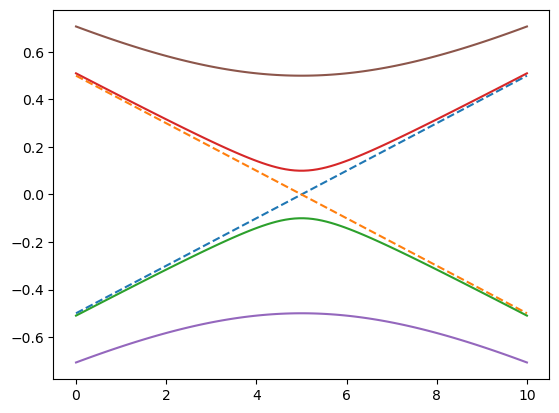

In [185]:
Ht = Hfunc(v=0.1,t0=5,U=0.1)
time = np.linspace(0,10,100)
E0 = np.vstack([np.diag(Ht(t1)) for t1 in time])
Et1 = np.vstack([np.sort(np.linalg.eigvals(Ht(t1))) for t1 in time])
Ht = Hfunc(v=0.1,t0=5,U=0.5)
Et2 = np.vstack([np.sort(np.linalg.eigvals(Ht(t1))) for t1 in time])

fig,ax=PLT.subplots()
ax.plot(time, E0,'--')
ax.plot(time, Et1)
ax.plot(time, Et2)

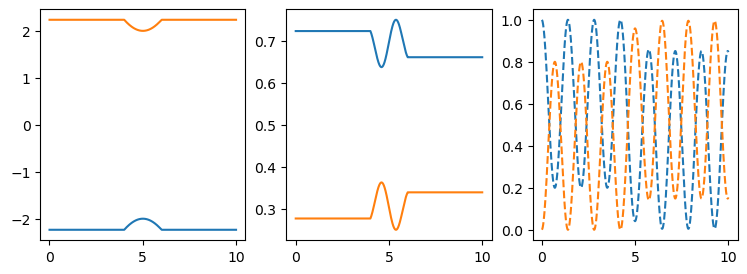

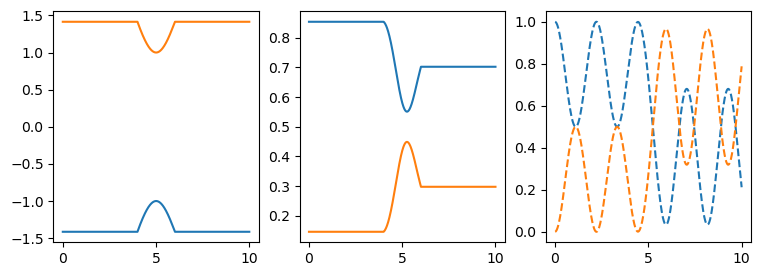

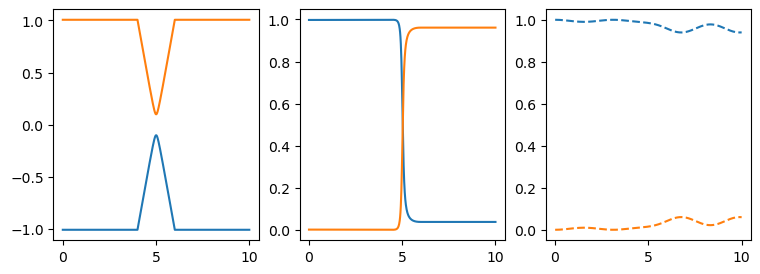

In [212]:
for U in [2,1,0.1]:
    psit, phit,E,time = propagator(10, Hfunc(v=1,t0=5,U=U), 0.01, psi=[1.,0.])
    fig,axs=PLT.subplots(ncols=3,figsize=(9,3))
    axs[0].plot(time, E)
    axs[1].plot(time, np.abs(phit[:,:])**2)
    axs[2].plot(time, np.abs(psit[:,:])**2,'--')
    



In [35]:
resid.shape

(1000,)